# CS 4E03 Energy System Research Project 1

<b>Author</b>: Jingze Dai, McMaster University
<br>
<b>Supervisor</b>: Dr.Douglas Down, Department of Computing and Software, McMaster University

<a name="toc"></a>
## Table of Contents
* [Section 1: Summary of Section Structures](#first-bullet)
* [Section 2: Simulation Code](#second-bullet)
* [Section 3: Extra Statistical Programs](#third-bullet)
  * [Subsection 3.1: Calculate the expected number of jobs](#sbs3-1)
  * [Subsection 3.2: Calculate the sum of all OFF and ON states' steady-state probability](#sbs3-2)
  * [Subsection 3.3: Calculate the sum of all idle and non-idle states](#sbs3-3)
  * [Subsection 3.4: Rendering a simplified transition diagram (when max_jobs = 5)](#sbs3-4)
  * [Subsection 3.5: Customized total cost functions](#sbs3-5)
* [Section 4: Programs to find the optimized parameters (with the minimal power consumption)](#bullet4)
  * [Subsection 4.1: Binary search when k1 = 1, and k2 = 1 to 500](#sbs4-1)
    * [Subsection 4.1.1: Sub-section 4.1 Results' Visualization](#sbss4-1-1)
  * [Subsection 4.2: Binary search when k1 = k2, both k1 and k2 from 1 to 500](#sbs4-2)
    * [Subsection 4.2.1: Sub-section 4.2 Results' Visualization](#sbss4-2-1)
  * [Subsection 4.3: Binary search when k1 = 1 to 500 and k2 = 500](#sbs4-3)
    * [Subsection 4.3.1: Sub-section 4.3 Results' Visualization](#sbss4-3-1)
  * [Subsection 4.4: Brute-Force boxing-comparison method](#sbs4-4)
  * [Subsection 4.5: 1000-Sample Random Search](#sbs4-5)
  * [Subsection 4.6: Simulated Annealing](#sbs4-6)
* [Section 5: Programs to find the optimized parameters (with the minimal total cost)](#bullet5)
  * [Subsection 5.1: Binary search when k1 = 1, and k2 = 1 to 500](#sbs5-1)
    * [Subsection 5.1.1: Sub-section 4.1 Results' Visualization](#sbss5-1-1)
  * [Subsection 5.2: Binary search when k1 = k2, both k1 and k2 from 1 to 500](#sbs5-2)
    * [Subsection 5.2.1: Sub-section 4.2 Results' Visualization](#sbss5-2-1)
  * [Subsection 5.3: Binary search when k1 = 1 to 500 and k2 = 500](#sbs5-3)
    * [Subsection 5.3.1: Sub-section 4.3 Results' Visualization](#sbss5-3-1)

<a class="anchor" id="first-bullet"><h3><b>Section 1</b>: Summary of Section Structures</h3></a> 
<br>
[Back to Menu](#toc)

<b>Section 1</b>: Summary of Section Structures
<ul>
  <li><b>This Section</b></li>
  <li>Introduces each section's main contents, for a better understanding of readers.</li>
</ul>

<b>Section 2</b>: Simulation Code
<ul>
  <li><b>Main body of the simulated model of energy systems</b></li>
  <li><i>Step 1</i>: Construct a CTMC with given parameters.</li>
  <li><i>Step 2</i>: Compute all states' steady-state probability.</li>
  <li><i>Step 3</i>: Compute the whole system's energy consumption cost.</li>
  <li><i>Step 4</i>: Compute the whole system's total cost.</li>
</ul>

<b>Section 3</b>: Extra Statistical Programs
<ul>
  <li>Supplemental helpful programs for diverse calculations.</li>
</ul>

<b>Section 4</b>: Programs to find the optimized parameters (with the minimal power consumption)
<ul>
  <li>Grid search programs to determine the optimal parameter group with the minimized power consumption cost.</li>
</ul>

<b>Section 5</b>: Programs to find the optimized parameters (with the minimal cost)
<ul>
  <li>Grid search programs to determine the optimal parameter group with the minimized total cost.</li>
</ul>

<a class="anchor" id="second-bullet"><h3><b>Section 2</b>: Simulation Code</h3></a> 
<br>
[Back to Menu](#toc)

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from scipy.linalg import solve
import time

# Count this program's running time
start_time = time.time()

def initialize_parameters():
    global arrival_rate, serve_rate, enhanced_serve_rate, turnon_rate, idle_rate, idle_power_cost
    global k1, k2, will_turn_off
    global power_OFF_idle, power_OFF_on, power_ON_idle, power_ON_reg, power_ON_enhanced, beta
    
    """
    lambda - the arrival rate                                                       -> Constant
    mu     - the service rate                                                       -> Constant
    mu bar - the enhanced service rate (when there are too many waiting jobs)       -> Constant
    gamma  - the rate at which system turns on (turnon_rate)                        -> Constant
    alpha  - the rate at which system turns off with no tasks (idle_rate)           -> Constant
    sigma  - the power consumption in the idle state                                -> Constant
    """
    # To make the system stable, assume lambda < mu
    # The enhanced serve rate (lambda_bar) must be smaller than the normal serve rate
    # Both the turn on rate and the idle rate must be greater than 0
    arrival_rate = 0.05
    serve_rate = 1.0
    enhanced_serve_rate = 1.1
    turnon_rate = 0.8
    idle_rate = 0.1
    idle_power_cost = 0.5

    """
    Threshold k1 - the amount of jobs triggering the energy system to turn on                          -> Variable
    Threshold k2 - the amount of jobs triggering the energy system to use the enhanced service rate    -> Variable
    The decision on whether the energy system will turn off once it becomes idle (True or False)       -> Variable
    """
    k1, k2 = 5, 5
    will_turn_off = True

    """
    Power consumption definitions
    Off states being idle (note serving any jobs): 0 power consumption               -> Constant
    Off states turning on: 1 power consumption                                       -> Constant
    On states being idle (note serving any jobs): 0.5 power consumption              -> Constant
    On states processing at regular rates: 1 power consumption                       -> Constant
    On states processing at enhanced rates: (enhanced rate) ^ 2 power consumption    -> Constant
    beta (Power consumption weights in the total cost calculation)                   -> Constant
    """
    power_OFF_idle = 0.0
    power_OFF_on = 1.0
    power_ON_idle = idle_power_cost
    power_ON_reg = 1.0
    power_ON_enhanced = enhanced_serve_rate ** 2
    beta = 500

def setup_States():
    global max_jobs, states, n_states
    # States starting with "OFF" mean OFF, and states starting with "ON" mean ON
    # State name's number represents the amount of waiting jobs
    # e.g., State OFF_0 represents the system is off, and there is 0 job inside the system
    # Example: states = ['OFF_0', 'OFF_1', 'OFF_2', 'OFF_3', 'OFF_4', 'OFF_5', 'ON_0', 'ON_1', 'ON_2', 'ON_3', 'ON_4', 'ON_5']
    max_jobs = 500
    states = [f'OFF_{i}' for i in range(max_jobs + 1)] + [f'ON_{i}' for i in range(max_jobs + 1)]
    n_states = len(states)

# Exception Handling for discovering unexpected parameter values.
def exception_handling():
    # Part 1: Check whether constant parameters' values are in the appropriate range.
    if arrival_rate <= 0 or arrival_rate >= 1:
        raise Exception("Problem: Illegal arrival rate values")
    if serve_rate != 1:
        raise Exception("Problem: Illegal service rate values")
    if arrival_rate >= serve_rate:
        raise Exception("Problem: Unstable System: arrival rate > serving rate")
    if serve_rate >= enhanced_serve_rate:
        raise Exception("Problem: Enhanced serve rate must be greater than normal serve rate")
    if turnon_rate <= 0:
        raise Exception("Problem: Illegal turn-on rate values")
    if idle_rate <= 0:
        raise Exception("Problem: Illegal idle rate values")
    if idle_power_cost <= 0 or idle_power_cost >= 1:
        raise Exception("Problem: Illegal idle power cost values")    
    # Part 2: Check whether variable parameters' values are in the appropriate range.
    if k1 > k2:
        raise Exception("Problem: Illegal threshold k1 and k2 values")
    if not (1 <= k1 <= max_jobs):
        raise Exception("Problem: Illegal threshold k1 value")
    if not (1 <= k2 <= max_jobs):
        raise Exception("Problem: Illegal threshold k2 value")

# Construct the transition matrix for further computing
def setup_Transition_Matrix():
    global transition_matrix, transitions, state_indices, transition_df
    transition_matrix = np.zeros((n_states, n_states))
    transitions = {}

    # Adding transitions for all ON and OFF states
    for i in range(max_jobs):
        transitions[(f'OFF_{i}', f'OFF_{i + 1}')] = arrival_rate
        transitions[(f'ON_{i}', f'ON_{i + 1}')] = arrival_rate

    for i in range(k1, max_jobs + 1):
        transitions[(f'OFF_{i}', f'ON_{i}')] = turnon_rate

    for i in range(1, k2 + 1):
        transitions[(f'ON_{i}', f'ON_{i - 1}')] = serve_rate

    for i in range(k2 + 1, max_jobs + 1):
        transitions[(f'ON_{i}', f'ON_{i - 1}')] = enhanced_serve_rate
    
    # The idle rate only works when the system determines to turn off
    # Otherwise, the system will not go back to state 'OFF_0'
    if will_turn_off is True:
        transitions[('ON_0', 'OFF_0')] = idle_rate
    
    state_indices = {state: i for i, state in enumerate(states)}
    for (from_state, to_state), rate in transitions.items():
        i, j = state_indices[from_state], state_indices[to_state]
        transition_matrix[i, j] = rate

    row_sums = transition_matrix.sum(axis=1)
    for i in range(n_states):
        transition_matrix[i, i] = -row_sums[i]

    # Convert to CSR format (or keep as a dense array if needed for other operations)
    transition_matrix = csr_matrix(transition_matrix)

    # Convert the sparse matrix to a dense array for DataFrame construction
    transition_df = pd.DataFrame(transition_matrix.toarray(), index=states, columns=states)

# Calculate each states' steady-state probability
def calculate_Steady_State(probabilityPrint=False, errorPrint=True):
    global steady_state_probs, steady_state_df, min_prob

    Q = transition_matrix.toarray().T
    Q[-1, :] = 1  # Replace the last equation with the normalization condition

    b = np.zeros(n_states)
    b[-1] = 1

    steady_state_probs = solve(Q, b)
    steady_state_df = pd.DataFrame(steady_state_probs, index=states, columns=["Probability"])

    # Checkes whether or not there are null and indefinite values 
    # Because null and infinite values are serious problems, we have to shut down running
    if np.any(np.isnan(steady_state_probs)) or np.any(np.isinf(steady_state_probs)):
        print("Error: Steady-state probabilities contain NaNs or infinities.")
        return

    # Print steady-state proability if required
    if probabilityPrint:
        print("Steady-State Probabilities:")
        print(steady_state_df)

    # Check the magnitude of negative steady-state probability values
    # If all negative values are too small, then it is OK
    min_prob = steady_state_df.min().values[0]
    if abs(min_prob) >= 1e-8 and min_prob < 0:
        if errorPrint:
            print(f"The minimum steady-state probability {min_prob} is significant.")
    elif errorPrint:
        print(f"The minimum steady-state probability {min_prob} approaches 0, can be ignored.")

    # Check the amount of negative steady-state probability values
    negative_indices = np.where(steady_state_probs < 0)[0]
    if len(negative_indices) > 0:
        if errorPrint:
            print(f"Warning: Found {len(negative_indices)} negative values in steady-state probabilities")
        # Optionally handle negative values here
    elif errorPrint:
        print("NO NEGATIVE steady-state probability values")

    # Check whether all steady-state probability values sum up to 1.
    sum_prob = steady_state_probs.sum()
    if not np.isclose(sum_prob, 1):
        if errorPrint:
            print(f"Warning: The sum of steady-state probabilities is {sum_prob}, which is not close to 1.")
    else:
        if errorPrint:
            print("Sum is 1, Good.")

# Power consumption calculations
# Example: State A has steady state probability 0.3, State B 0.5, and State C 0.2.
# State A power consumption 1, State B 2, and State C 3.
# Total energy consumption = 1 * 0.3 + 2 * 0.5 + 3 * 0.2 = 1.9. -> Suming up each state's power consumption.
def calculate_Power_Consumption():
    global power_consumption, power_consumption_sum, power_consumption_list
    power_consumption = {f'OFF_{i}': power_OFF_on if i >= k1 else power_OFF_idle for i in range(max_jobs + 1)}
    power_consumption.update({f'ON_{i}': power_ON_reg if i < k2 + 1 else power_ON_enhanced for i in range(max_jobs + 1)})
    power_consumption.update({'ON_0': power_ON_idle})

    # Compute each state's power consumption, and recording these values on a list
    power_consumption_list = np.array(
        [steady_state_probs[i] * power_consumption[states[i]] for i in range(len(steady_state_probs))])
    power_consumption_sum = np.sum(power_consumption_list) # Calculate the whole system's energy consumption
    
# Calculate Total Cost
def calculate_Cost(steady_state_df):
    global total_cost, expected_jobs
    probabilities = np.array(steady_state_df["Probability"].values)
    jobs = np.array([int(state.split('_')[1]) for state in steady_state_df.index])
    expected_jobs = np.dot(jobs, probabilities)

    # Formula: Total cost = total power consumption * the power consumption weights + expected number of jobs
    total_cost = power_consumption_sum * beta + expected_jobs

# Model Execution
initialize_parameters()
setup_States()
exception_handling()
setup_Transition_Matrix()
calculate_Steady_State(False, True)
calculate_Power_Consumption()
calculate_Cost(steady_state_df)

# Display various results below
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

print("\nTransition Matrix:")
print(transition_df)
print("\n")

print("\nSteady-State Probabilities:")
print(steady_state_df)
print("\n")

# Print out first 10 OFF states
print(steady_state_df.loc['OFF_0'])
print(steady_state_df.loc['OFF_1'])
print(steady_state_df.loc['OFF_2'])
print(steady_state_df.loc['OFF_3'])
print(steady_state_df.loc['OFF_4'])
print(steady_state_df.loc['OFF_5'])
print(steady_state_df.loc['OFF_6'])
print(steady_state_df.loc['OFF_7'])
print(steady_state_df.loc['OFF_8'])
print(steady_state_df.loc['OFF_9'])
print("\n")

# Print out first 10 ON states
print(steady_state_df.loc['ON_0'])
print(steady_state_df.loc['ON_1'])
print(steady_state_df.loc['ON_2'])
print(steady_state_df.loc['ON_3'])
print(steady_state_df.loc['ON_4'])
print(steady_state_df.loc['ON_5'])
print(steady_state_df.loc['ON_6'])
print(steady_state_df.loc['ON_7'])
print(steady_state_df.loc['ON_8'])
print(steady_state_df.loc['ON_9'])
print("\n")

print("\nIndividual-State Expected Power Consumption Values:")
print(power_consumption)

print("\nEach State's Actual Power Consumption (During Calculation):")
print(power_consumption_list)

print("\nTotal Power Consumption: " + str(power_consumption_sum))

print("\nTotal Cost: " + str(total_cost))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nCalculation time: {elapsed_time:.6f} seconds")

The minimum steady-state probability -0.0 approaches 0, can be ignored.
NO NEGATIVE steady-state probability values
Sum is 1, Good.

Transition Matrix:
        OFF_0  OFF_1  OFF_2  OFF_3  OFF_4  OFF_5  OFF_6  OFF_7  OFF_8  OFF_9  \
OFF_0   -0.05   0.05   0.00   0.00   0.00   0.00    0.0    0.0    0.0    0.0   
OFF_1    0.00  -0.05   0.05   0.00   0.00   0.00    0.0    0.0    0.0    0.0   
OFF_2    0.00   0.00  -0.05   0.05   0.00   0.00    0.0    0.0    0.0    0.0   
OFF_3    0.00   0.00   0.00  -0.05   0.05   0.00    0.0    0.0    0.0    0.0   
OFF_4    0.00   0.00   0.00   0.00  -0.05   0.05    0.0    0.0    0.0    0.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
ON_496   0.00   0.00   0.00   0.00   0.00   0.00    0.0    0.0    0.0    0.0   
ON_497   0.00   0.00   0.00   0.00   0.00   0.00    0.0    0.0    0.0    0.0   
ON_498   0.00   0.00   0.00   0.00   0.00   0.00    0.0    0.0    0.0    0.0   
ON_499   0.00   0.00   0.00   0.00   0.00   0.00

<a class="anchor" id="third-bullet"><h3><b>Section 3</b>: Extra Statistical Programs</h3></a> 
<br>
[Back to Menu](#toc)

<b>Reminder: Before running this section's programs, please run the section 2 simulation model first.</b>

<p><b><a class="anchor" id="sbs3-1">Function 1</a></b>: Calculate the expected number of jobs</p>

In [31]:
import numpy as np

start_time = time.time()

# Method: Multiply each state's steady-state probability with their corresponding numbers of jobs
def calculate_expected_jobs(steady_state_df):
    probabilities = np.array(steady_state_df["Probability"].values)
    jobs = np.array([int(state.split('_')[1]) for state in steady_state_df.index])
    expected_jobs = np.dot(jobs, probabilities)

    return expected_jobs

print(f"Expected Number of Jobs in the Energy System: {calculate_expected_jobs(steady_state_df):.6f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nCalculation time: {elapsed_time:.6f} seconds")

Expected Number of Jobs in the Energy System: 2.478097

Calculation time: 0.000965 seconds


<p><b><a class="anchor" id="sbs3-2">Function 2</a></b>: Calculate the sum of all OFF and ON states' steady-state probability</p>

In [8]:
# Find all ON and OFF states' sum of steady-state probability
off_states = [state for state in steady_state_df.index if state.startswith('OFF')]
on_states = [state for state in steady_state_df.index if state.startswith('ON')]

sum_off_states = steady_state_df.loc[off_states].sum().values[0]
sum_on_states = steady_state_df.loc[on_states].sum().values[0]

print(f"Sum of steady-state probabilities for all OFF states: {sum_off_states:.6f}")
print(f"Sum of steady-state probabilities for all ON states: {sum_on_states:.6f}")

Sum of steady-state probabilities for all OFF states: 0.345324
Sum of steady-state probabilities for all ON states: 0.654676


<p><b><a class="anchor" id="sbs3-3">Function 3</a></b>: Calculate the sum of all idle and non-idle states</p>

In [4]:
# Find all idle and non-idle states' sum of steady-state probability
idle_states = [state for state in steady_state_df.index if state.endswith('0')]
non_idle_states = [state for state in steady_state_df.index if not state.endswith('0')]

sum_idle_states = steady_state_df.loc[idle_states].sum().values[0]
sum_non_idle_states = steady_state_df.loc[non_idle_states].sum().values[0]

print(f"Sum of steady-state probabilities for all idle states: {sum_idle_states:.6f}")
print(f"Sum of steady-state probabilities for all non-idle states: {sum_non_idle_states:.6f}")

Sum of steady-state probabilities for all idle states: 0.335290
Sum of steady-state probabilities for all non-idle states: 0.664710


<p><b><a class="anchor" id="sbs3-4">Function 4</a></b>: Rendering a simplified transition diagram (when max_jobs = 5)</p>

In [ ]:
# Enable plot interactivity
%matplotlib notebook

<IPython.core.display.Javascript object>


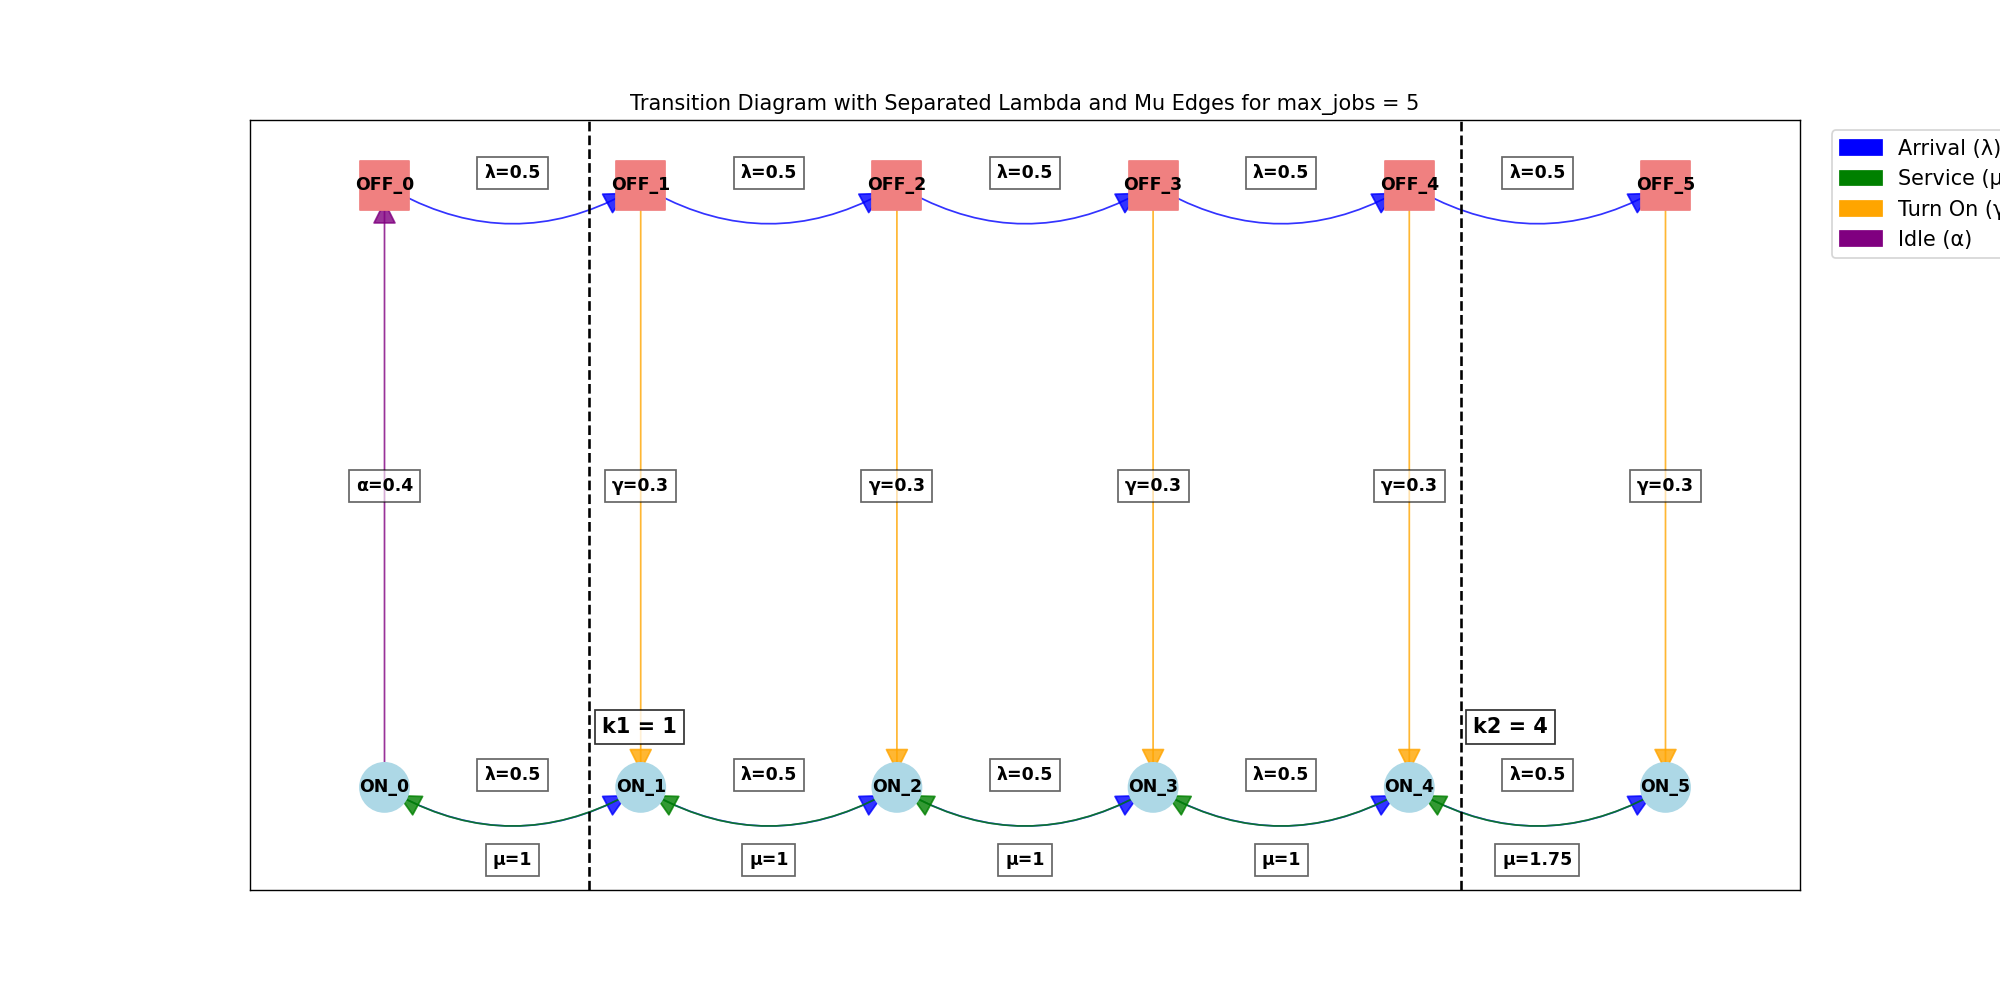

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

'''
Generate a simplified model's transition diagram, with a maximum job capacity of 5 jobs.
(In realistic situations, the maximal job capacity should be infinite.)
1. 6 OFF states: OFF_0 to OFF_5, where the state OFF_0 is the OFF state.
2. 6 ON states: ON_0 to ON_5, where the state ON_0 is the IDLE state.
3. k1 = 2, so when there are >= 2 jobs in the system, the system will start to turn on.
4. k2 = 4, so when there are >= 4 jobs in the system, the system will switch to an enhanced service rate.
'''

def draw_transition_diagram_with_separated_edges(max_jobs=5):
    G = nx.DiGraph()
    
    arrival_rate = 0.5
    serve_rate = 1
    enhanced_serve_rate = 1.75
    turnon_rate = 0.3
    idle_rate = 0.4
    
    k2 = 4
    will_turn_off = True

    off_states = [f'OFF_{i}' for i in range(max_jobs + 1)]
    on_states = [f'ON_{i}' for i in range(max_jobs + 1)]
    
    for state in off_states:
        G.add_node(state, color='lightcoral', node_type='s')  # Square for OFF states

    for state in on_states:
        G.add_node(state, color='lightblue', node_type='o')  # Circle for ON states

    for i in range(max_jobs):
        G.add_edge(f'OFF_{i}', f'OFF_{i + 1}', label=f'λ={arrival_rate}', layer='arrival')
    
    for i in range(max_jobs):
        G.add_edge(f'ON_{i}', f'ON_{i + 1}', label=f'λ={arrival_rate}', layer='arrival')

    for i in range(1, max_jobs + 1):
        G.add_edge(f'OFF_{i}', f'ON_{i}', label=f'γ={turnon_rate}', layer='turnon')

    for i in range(1, max_jobs + 1):
        service_rate = serve_rate if i <= k2 else enhanced_serve_rate
        G.add_edge(f'ON_{i}', f'ON_{i - 1}', label=f'μ={service_rate}', layer='service')

    if will_turn_off:
        G.add_edge('ON_0', 'OFF_0', label=f'α={idle_rate}', layer='idle')

    pos = {}
    for i, state in enumerate(off_states):
        pos[state] = (i, 1)

    for i, state in enumerate(on_states):
        pos[state] = (i, 0)

    plt.figure(figsize=(16, 8))

    node_colors = [nx.get_node_attributes(G, 'color')[node] for node in G.nodes()]
    node_shapes = [nx.get_node_attributes(G, 'node_type')[node] for node in G.nodes()]
    
    for shape in set(node_shapes):
        nodelist = [node for node in G.nodes() if nx.get_node_attributes(G, 'node_type')[node] == shape]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_shape=shape, 
                               node_color=[nx.get_node_attributes(G, 'color')[node] for node in nodelist], node_size=800)

    lambda_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('layer') == 'arrival']
    nx.draw_networkx_edges(G, pos, edgelist=lambda_edges, edge_color='blue', arrowstyle='-|>', 
                           connectionstyle='arc3, rad = 0.3', arrowsize=30, alpha=0.8)

    service_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('layer') == 'service']
    nx.draw_networkx_edges(G, pos, edgelist=service_edges, edge_color='green', arrowstyle='-|>', 
                           connectionstyle='arc3, rad = -0.3', arrowsize=30, alpha=0.8)

    turnon_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('layer') == 'turnon']
    nx.draw_networkx_edges(G, pos, edgelist=turnon_edges, edge_color='orange', arrowstyle='-|>', 
                           connectionstyle='arc3', arrowsize=30, alpha=0.8)

    idle_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('layer') == 'idle']
    nx.draw_networkx_edges(G, pos, edgelist=idle_edges, edge_color='purple', arrowstyle='-|>', 
                           connectionstyle='arc3', arrowsize=30, alpha=0.8)

    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', verticalalignment='center')

    ax = plt.gca()
    for edge in G.edges(data=True):
        start, end, data = edge
        label = data.get('label', '')
        x_start, y_start = pos[start]
        x_end, y_end = pos[end]
        x = (x_start + x_end) / 2
        y = (y_start + y_end) / 2
        if data.get('layer') == 'arrival':
            y += 0.02
        elif data.get('layer') == 'service':
            y -= 0.12
        ax.text(x, y, label, fontsize=10, fontweight='bold', color='black', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))

    x_border_0 = max_jobs - 4.2
    plt.axvline(x=x_border_0, color='black', linestyle='--', linewidth=1.5)
    plt.text(x_border_0 + 0.05, 0.1, 'k1 = 1', fontsize=12, fontweight='bold', color='black', ha='left', va='center', bbox=dict(facecolor='white', alpha=0.8))

    x_border_1 = max_jobs - 0.8
    plt.axvline(x=x_border_1, color='black', linestyle='--', linewidth=1.5)
    plt.text(x_border_1 + 0.05, 0.1, 'k2 = 4', fontsize=12, fontweight='bold', color='black', ha='left', va='center', bbox=dict(facecolor='white', alpha=0.8))

    legend_patches = [
        mpatches.Patch(color='blue', label='Arrival (λ)'),
        mpatches.Patch(color='green', label='Service (μ)'),
        mpatches.Patch(color='orange', label='Turn On (γ)'),
        mpatches.Patch(color='purple', label='Idle (α)')
    ]
    plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=12)

    plt.title(f"Transition Diagram with Separated Lambda and Mu Edges for max_jobs = {max_jobs}")
    plt.show()

draw_transition_diagram_with_separated_edges(5)

<p><b><a class="anchor" id="sbs3-5">Function 5</a></b>: Customized total cost functions</p>

In [5]:
'''
OPTIONAL: A most complicated total cost function: Single-Threshold and Binary-cost-level function
While the expected amount of jobs is smaller than or equals the given threshold, each waiting job's cost is a constant
And while it exceeds this given threshold, the cost will be doubled
'''

def calculate_total_cost_extra_0(capacity_threshold):
    if expected_jobs > capacity_thresh4old:
        return capacity_threshold * 2 + (expected_jobs - capacity_threshold) + beta * power_consumption_sum
    else:
        return expected_jobs + beta * power_consumption_sum

print("Expected total cost via using customized total cost functions: ")
calculate_total_cost_extra_0(1)

Expected total cost via using customized total cost functions: 


4.126483817358218

<a class="anchor" id="bullet4"><h3><b>Section 4</b>: Programs to find the optimized parameters (with the lowest power consumption)</h3></a> 
<br>
[Back to Menu](#toc)

<b>Reminder: Before running this section's programs, please run the section 2 simulation model first.</b>

This grid search has used 4 different algorithms to find the parameter group with minimal power consumption:
* Binary search (including 3 sections - 4.1 to 4.3)
* Brute-Force boxing-comparison method (Through all cases, very time-consuming) (Section 4.4)
* 1000-Sample random search (Section 4.5)
* Simulated Annealing (Section 4.6)

<p><b><a class="anchor" id="sbs4-1">Sub-section 1</a></b>: Binary search when k1 = 1, and k2 = 1 to 500</p>

In [2]:
import numpy as np
import pandas as pd
import time
from itertools import product

# Count this program's running time
start_time = time.time()

def grid_search_0():
    global power_OFF_idle, power_OFF_on, power_ON_reg, power_ON_enhanced
    global k1, k2, will_turn_off
    global power_consumption_plots_0, power_consumption_plots_1
    # Initial parameters set up
    initialize_parameters()
    setup_States()
    exception_handling()
    setup_Transition_Matrix()

    # Initial Parameter (Abstract and not available in the realistic situations)
    best_params = [0, 0, False]
    best_power_consumption = float('inf')
    # Record all parameter groups' power consumption values (For further plots)
    # power_consumption_plots_0: plots when will_turn_off = False
    # power_consumption_plots_1: plots when will_turn_off = True
    power_consumption_plots_0 = []
    power_consumption_plots_1 = []

    k1 = 1
    for k2, b1 in product(range(k1, max_jobs + 1), [True, False]):
        if k1 <= k2:         
            k1, k2 = k1, k2
            will_turn_off = b1

            setup_Transition_Matrix()
            calculate_Steady_State(False, False)
            calculate_Power_Consumption()

            # Add power consumptions inside the plot list
            if not will_turn_off:
                power_consumption_plots_0.append(power_consumption_sum)
            else:
                power_consumption_plots_1.append(power_consumption_sum)
            
            # Update the best parameter group once it finds a smaller power consumption value
            if power_consumption_sum < best_power_consumption:
                best_power_consumption = power_consumption_sum
                best_params = [k1, k2, will_turn_off]

    return best_params, best_power_consumption

best_params, best_power_consumption = grid_search_0()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: k1={best_params[0]}, k2={best_params[1]}, will_turn_off={best_params[2]}")
print(f"Minimum Power Consumption: {best_power_consumption}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: k1=1, k2=28, will_turn_off=True
Minimum Power Consumption: 0.449999999999986
Elapsed Time: 147.03 seconds


<p><b><a class="anchor" id="sbss4-1-1">Sub-section 1</a></b>- Results' Visualization</p>

In [3]:
# Enable plot interactivity
%matplotlib notebook

<IPython.core.display.Javascript object>


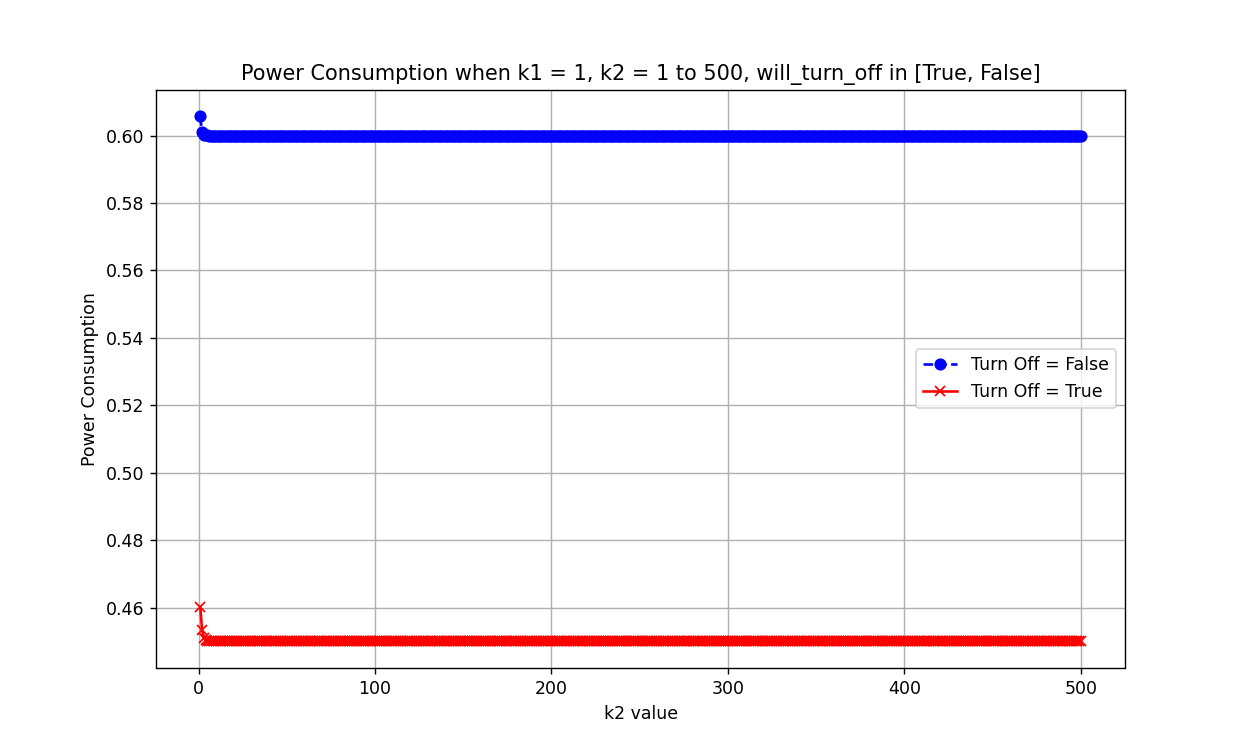

In [4]:
import matplotlib.pyplot as plt
import numpy as np

'''
Plot the above power consumption results into visualized diagrams
While the mouse cursor approaches curves, it will show k2 values and the power consumption value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_power_consumption():
    jobs_range = list(range(1, len(power_consumption_plots_0) + 1))

    fig, ax = plt.subplots(figsize=(10, 6))

    line1, = ax.plot(jobs_range, power_consumption_plots_0, label='Turn Off = False', color='blue', linestyle='--', marker='o')
    line2, = ax.plot(jobs_range, power_consumption_plots_1, label='Turn Off = True', color='red', linestyle='-', marker='x')

    ax.set_xlabel('k2 value')
    ax.set_ylabel('Power Consumption')
    ax.set_title('Power Consumption when k1 = 1, k2 = 1 to 500, will_turn_off in [True, False]')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.8f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for line in [line1, line2]:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(ind, line)
                    fig.canvas.draw_idle()
                    return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()

plot_power_consumption()

<IPython.core.display.Javascript object>


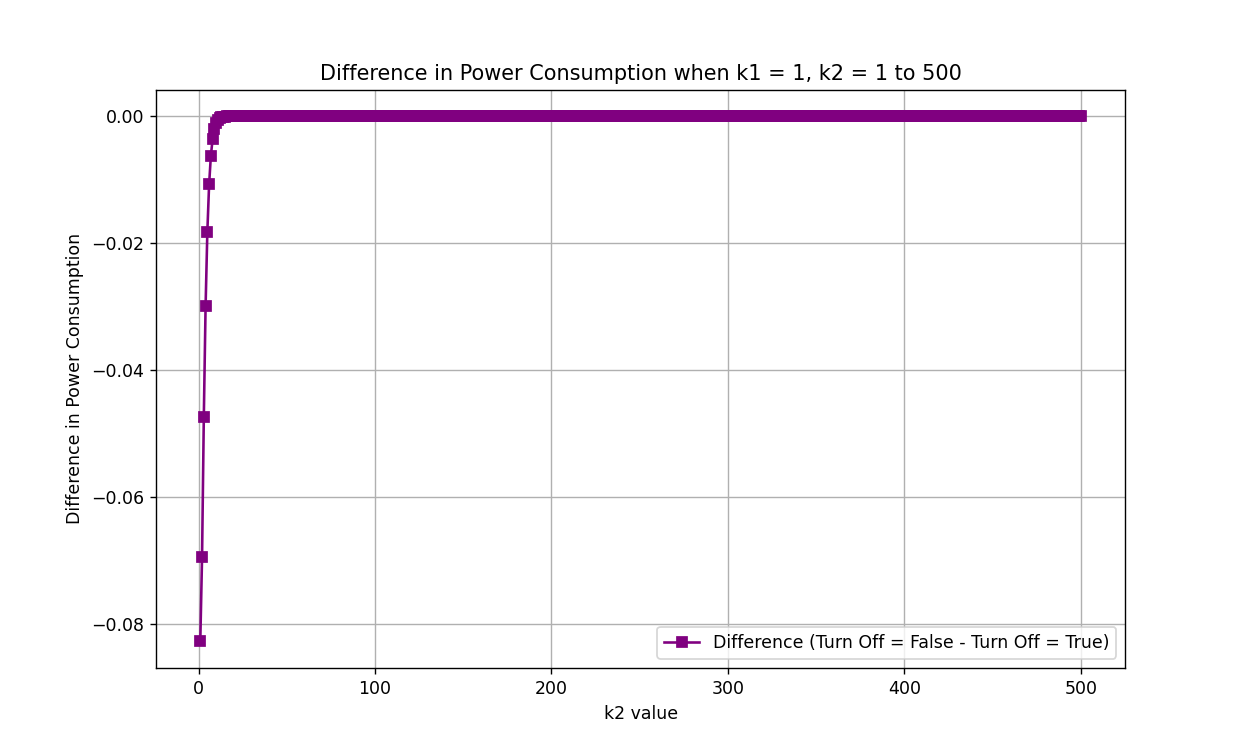

In [13]:
import matplotlib.pyplot as plt
import numpy as np

'''
Calculate both power consumption list's differences and plot them on a diagram
While the mouse cursor approaches curves, it will show k2 values and the power consumption value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_differences():
    differences = np.array(power_consumption_plots_0) - np.array(power_consumption_plots_1)
    
    jobs_range = list(range(1, len(differences) + 1))
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(jobs_range, differences, label='Difference (Turn Off = False - Turn Off = True)', color='purple', linestyle='-', marker='s')

    ax.set_xlabel('k2 value')
    ax.set_ylabel('Difference in Power Consumption')
    ax.set_title('Difference in Power Consumption when k1 = 1, k2 = 1 to 500')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.20f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind, line)
                fig.canvas.draw_idle()
                return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

plot_differences()

<p><b><a class="anchor" id="sbs4-2">Sub-section 2</a></b>: Binary search when k1 = k2, both k1 and k2 from 1 to 500</p>

In [14]:
import numpy as np
import pandas as pd
import time
from itertools import product

# Count this program's running time
start_time = time.time()

def grid_search_1():
    global power_OFF_idle, power_OFF_on, power_ON_reg, power_ON_enhanced
    global k1, k2, will_turn_off
    global power_consumption_plots_2, power_consumption_plots_3
    # Initial parameters set up
    initialize_parameters()
    setup_States()
    exception_handling()
    setup_Transition_Matrix()

    best_params = [0, 0, False]
    best_power_consumption = float('inf')

    # Record all parameter groups' power consumption values (For further plots)
    # power_consumption_plots_2: plots when will_turn_off = False
    # power_consumption_plots_3: plots when will_turn_off = True
    power_consumption_plots_2 = []
    power_consumption_plots_3 = []
    
    i = 1
    for j, will_turn_off in product(range(1, max_jobs + 1), [True, False]):
        i = j
        k1 = i
        k2 = j
        will_turn_off = will_turn_off

        setup_Transition_Matrix()
        calculate_Steady_State(False, False)
        calculate_Power_Consumption()

        # Add power consumptions inside the plot list
        if not will_turn_off:
            power_consumption_plots_2.append(power_consumption_sum)
        else:
            power_consumption_plots_3.append(power_consumption_sum)
        
        if power_consumption_sum < best_power_consumption:
            best_power_consumption = power_consumption_sum
            best_params = [k1, k2, will_turn_off]

    return best_params, best_power_consumption

best_params, best_power_consumption = grid_search_1()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: k1={best_params[0]}, k2={best_params[1]}, will_turn_off={best_params[2]}")
print(f"Minimum Power Consumption: {best_power_consumption}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: k1=500, k2=500, will_turn_off=True
Minimum Power Consumption: 0.5004990019959966
Elapsed Time: 41.94 seconds


<p><b><a class="anchor" id="sbss4-2-1">Sub-section 2</a></b>- Results' Visualization</p>

In [ ]:
# Enable plot interactivity
%matplotlib notebook

<IPython.core.display.Javascript object>


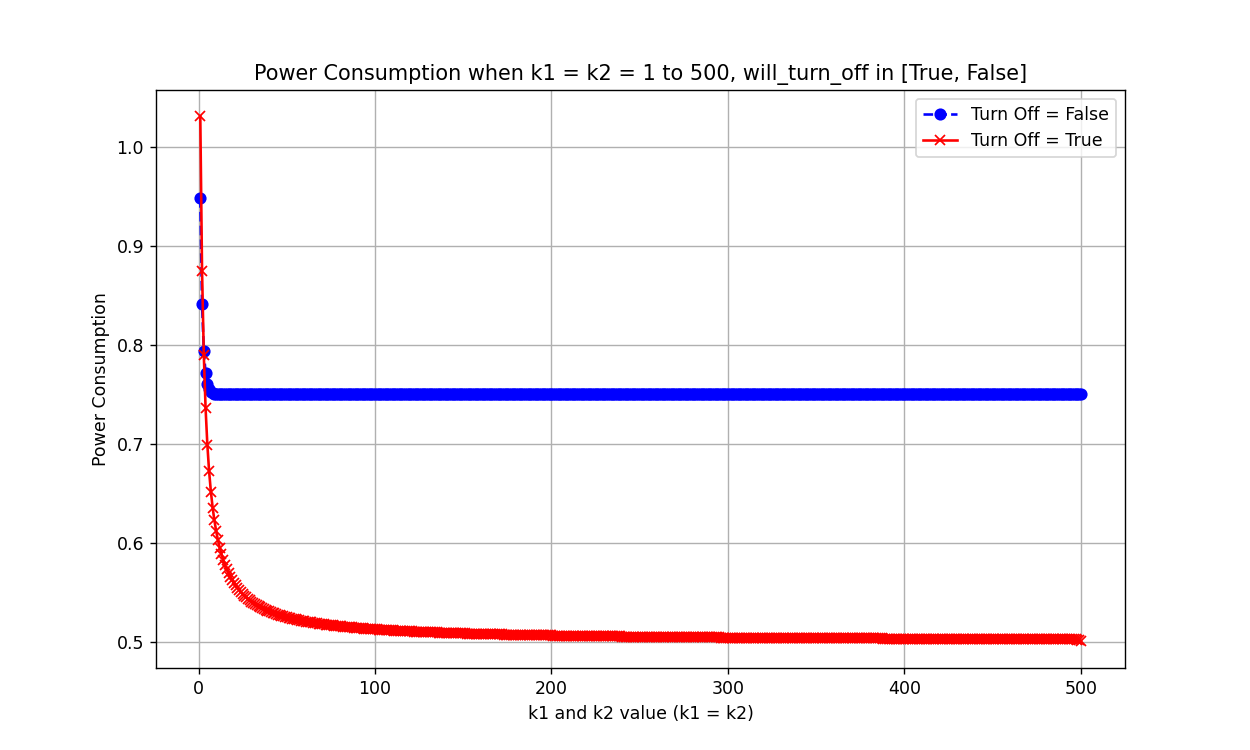

In [15]:
import matplotlib.pyplot as plt
import numpy as np

'''
Plot the above power consumption results into visualized diagrams
While the mouse cursor approaches curves, it will show k2 values and the power consumption value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_power_consumption():
    jobs_range = list(range(1, len(power_consumption_plots_2) + 1))

    fig, ax = plt.subplots(figsize=(10, 6))

    line1, = ax.plot(jobs_range, power_consumption_plots_2, label='Turn Off = False', color='blue', linestyle='--', marker='o')
    line2, = ax.plot(jobs_range, power_consumption_plots_3, label='Turn Off = True', color='red', linestyle='-', marker='x')

    ax.set_xlabel('k1 and k2 value (k1 = k2)')
    ax.set_ylabel('Power Consumption')
    ax.set_title('Power Consumption when k1 = k2 = 1 to 500, will_turn_off in [True, False]')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.8f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for line in [line1, line2]:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(ind, line)
                    fig.canvas.draw_idle()
                    return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()

plot_power_consumption()

<IPython.core.display.Javascript object>


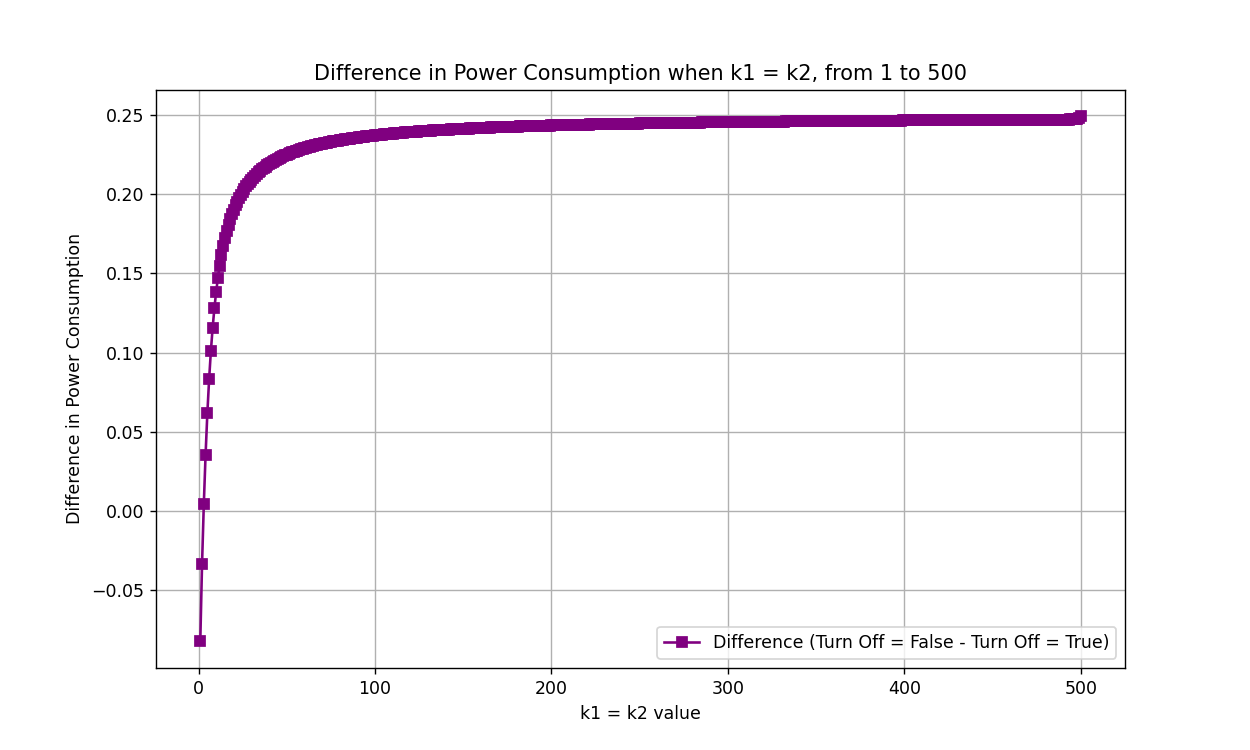

In [16]:
import matplotlib.pyplot as plt
import numpy as np

'''
Calculate both power consumption list's differences and plot them on a diagram
While the mouse cursor approaches curves, it will show k2 values and the power consumption value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_differences():
    differences = np.array(power_consumption_plots_2) - np.array(power_consumption_plots_3)
    
    jobs_range = list(range(1, len(differences) + 1))
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(jobs_range, differences, label='Difference (Turn Off = False - Turn Off = True)', color='purple', linestyle='-', marker='s')

    ax.set_xlabel('k1 = k2 value')
    ax.set_ylabel('Difference in Power Consumption')
    ax.set_title('Difference in Power Consumption when k1 = k2, from 1 to 500')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.20f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind, line)
                fig.canvas.draw_idle()
                return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

plot_differences()

<p><b><a class="anchor" id="sbs4-3">Sub-section 3</a></b>: Binary search when k1 = 1 to 500 and k2 = 500</p>

In [17]:
import numpy as np
import pandas as pd
import time
from itertools import product

# Count this program's running time
start_time = time.time()

def grid_search_2():
    global power_OFF_idle, power_OFF_on, power_ON_reg, power_ON_enhanced
    global k1, k2, will_turn_off
    global power_consumption_plots_4, power_consumption_plots_5
    # Initial parameters set up
    initialize_parameters()
    setup_States()
    exception_handling()
    setup_Transition_Matrix()

    best_params = [0, 0, False]
    best_power_consumption = float('inf')

    # Record all parameter groups' power consumption values (For further plots)
    # power_consumption_plots_4: plots when will_turn_off = False
    # power_consumption_plots_5: plots when will_turn_off = True
    power_consumption_plots_4 = []
    power_consumption_plots_5 = []
    
    j = 500
    for i, will_turn_off in product(range(1, max_jobs + 1), [True, False]):
        k1 = i
        k2 = j
        will_turn_off = will_turn_off

        setup_Transition_Matrix()
        calculate_Steady_State(False, False)
        calculate_Power_Consumption()

        # Add power consumptions inside the plot list
        if not will_turn_off:
            power_consumption_plots_4.append(power_consumption_sum)
        else:
            power_consumption_plots_5.append(power_consumption_sum)
        
        if power_consumption_sum < best_power_consumption:
            best_power_consumption = power_consumption_sum
            best_params = [k1, k2, will_turn_off]

    return best_params, best_power_consumption

best_params, best_power_consumption = grid_search_2()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: k1={best_params[0]}, k2={best_params[1]}, will_turn_off={best_params[2]}")
print(f"Minimum Power Consumption: {best_power_consumption}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: k1=500, k2=500, will_turn_off=True
Minimum Power Consumption: 0.5004990019959966
Elapsed Time: 42.66 seconds


<p><b><a class="anchor" id="sbss4-3-1">Sub-section 3</a></b>- Results' Visualization</p>

In [ ]:
# Enable plot interactivity
%matplotlib notebook

<IPython.core.display.Javascript object>


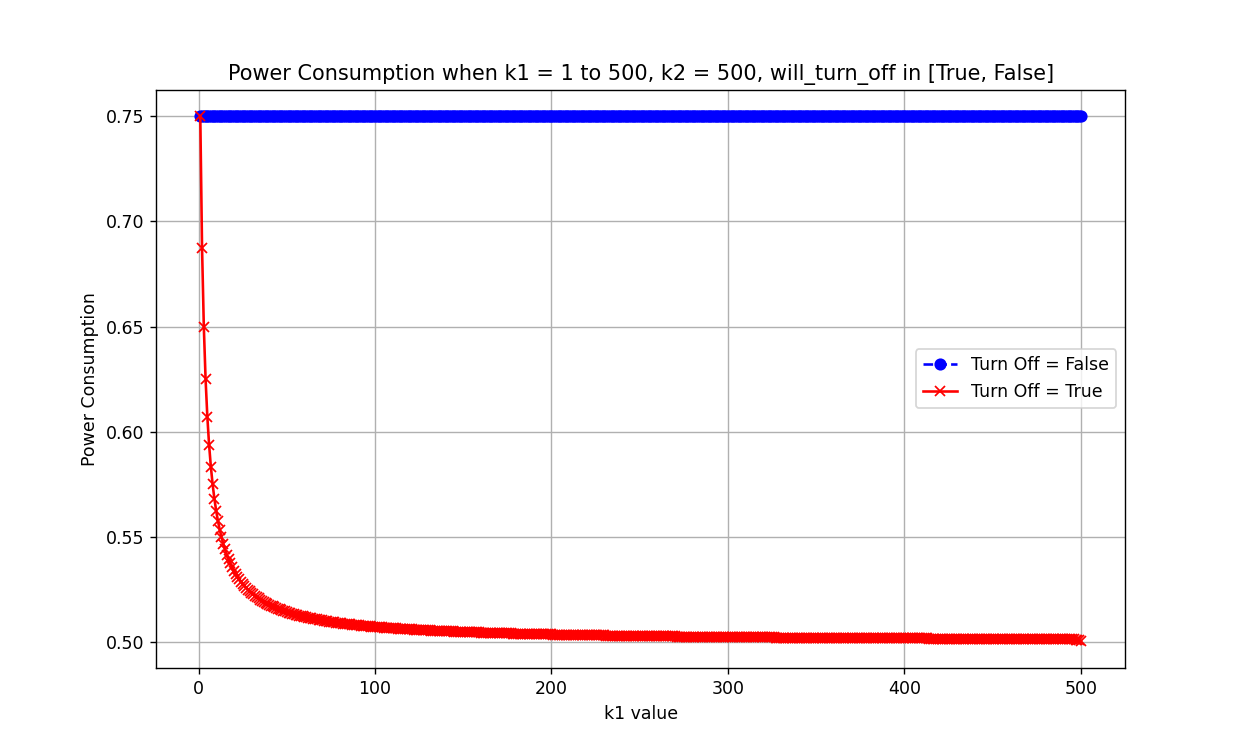

In [18]:
import matplotlib.pyplot as plt
import numpy as np

'''
Plot the above power consumption results into visualized diagrams
While the mouse cursor approaches curves, it will show k2 values and the power consumption value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_power_consumption():
    jobs_range = list(range(1, len(power_consumption_plots_4) + 1))

    fig, ax = plt.subplots(figsize=(10, 6))

    line1, = ax.plot(jobs_range, power_consumption_plots_4, label='Turn Off = False', color='blue', linestyle='--', marker='o')
    line2, = ax.plot(jobs_range, power_consumption_plots_5, label='Turn Off = True', color='red', linestyle='-', marker='x')

    ax.set_xlabel('k1 value')
    ax.set_ylabel('Power Consumption')
    ax.set_title('Power Consumption when k1 = 1 to 500, k2 = 500, will_turn_off in [True, False]')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.8f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for line in [line1, line2]:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(ind, line)
                    fig.canvas.draw_idle()
                    return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()

plot_power_consumption()

<IPython.core.display.Javascript object>


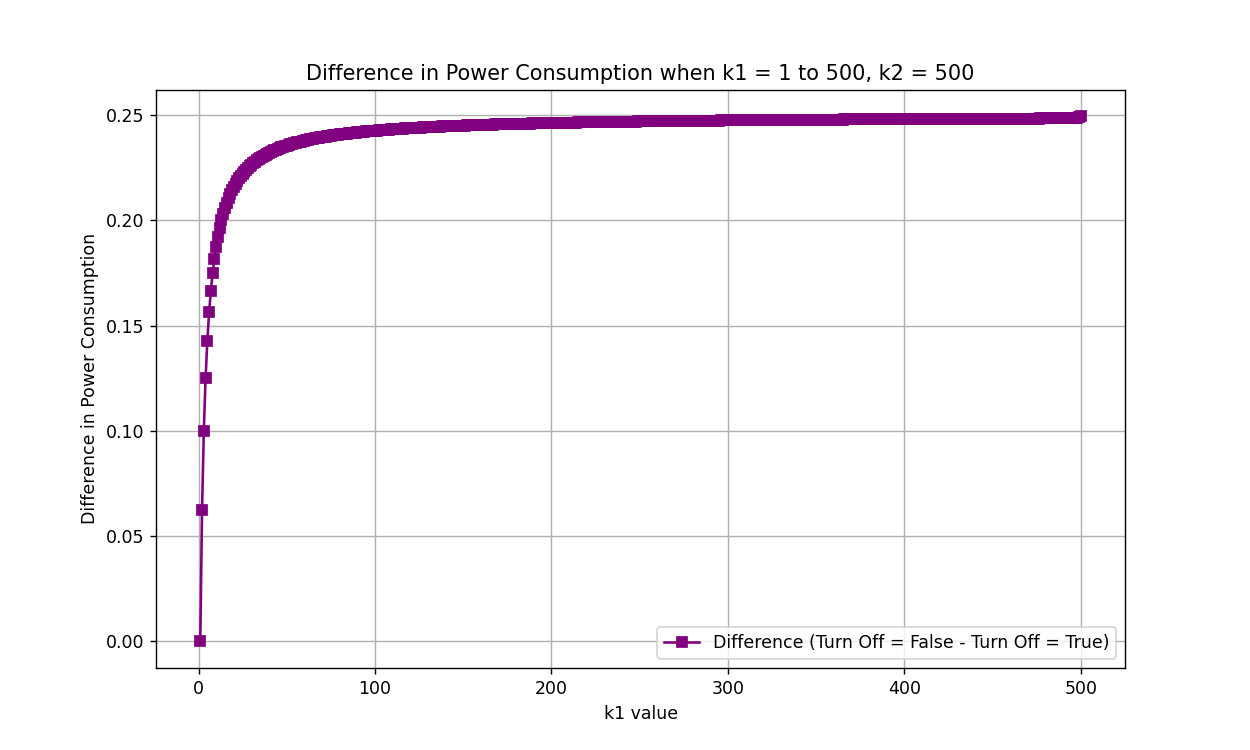

In [19]:
import matplotlib.pyplot as plt
import numpy as np

'''
Calculate both power consumption list's differences and plot them on a diagram
While the mouse cursor approaches curves, it will show k2 values and the power consumption value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_differences():
    differences = np.array(power_consumption_plots_4) - np.array(power_consumption_plots_5)
    
    jobs_range = list(range(1, len(differences) + 1))
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(jobs_range, differences, label='Difference (Turn Off = False - Turn Off = True)', color='purple', linestyle='-', marker='s')

    ax.set_xlabel('k1 value')
    ax.set_ylabel('Difference in Power Consumption')
    ax.set_title('Difference in Power Consumption when k1 = 1 to 500, k2 = 500')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.20f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind, line)
                fig.canvas.draw_idle()
                return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

plot_differences()

Seems like when k2 = 500, and will_turn_off = True gives the minimized power consumption value, whatever the values of k1 and other parameters are.

Then there is a "boxing" program: we guess this parameter group (k1 = 500, k2 = 500, and will_turn_off = True) is the best parameter, but we are not sure if there are any outliners or special parameter cases that leads to a lower value of power consumption. The optimal value is the beginning case. By using the brute-force method, we check every possible cases, and compare them with the given optimal ones. (If smaller then replace it).

One advantage is it saves a lot of calculation time.

If you want to find to save unnecessary time on calculating other constant groups' optimal power consumption value, these are recommended steps:
1. Modify other constants' values on section 2 models
2. Ignore other programs before, and directly run this program.

<b><a class="anchor" id="sbs4-4">Method 1</a>:</b> Brute-Force Boxing-Comparison Method (Taking so long time, I have not completed running it. However, By running a part of its parameter values, I did not find any smaller power consumption values.)

In [ ]:
def boxing_grid_search():
    global power_OFF_idle, power_OFF_on, power_ON_reg, power_ON_enhanced
    global k1, k2, will_turn_off
    global best_params, best_power_consumption

    # Initialize parameters
    initialize_parameters()
    setup_States()
    exception_handling()

    # Initial setup and calculations
    k1, k2, will_turn_off = 500, 500, True
    setup_Transition_Matrix()
    calculate_Steady_State(False, False)
    calculate_Power_Consumption()
    best_params = [k1, k2, will_turn_off]
    best_power_consumption = power_consumption_sum

    print("Initial Power Consumption: " + str(best_params))
    print("Power consumption: " + str(best_power_consumption))
    print()

    # Iterate over parameter ranges
    for i in range(1, 501):
        for j in range(i, 501):  # Start from i to avoid redundant calculations
            for k in [True, False]:  # Iterate over both possible values of will_turn_off
                k1, k2 = i, j
                will_turn_off = k
                try:
                    setup_Transition_Matrix()
                    calculate_Steady_State(False, False)
                    calculate_Power_Consumption()
                    
                    if power_consumption_sum < best_power_consumption:
                        best_power_consumption = power_consumption_sum
                        best_params = [k1, k2, will_turn_off]
                except Exception as e:
                    pass

    return best_params, best_power_consumption

import time

start_time = time.time()
best_params, best_power_consumption = boxing_grid_search()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: k1={best_params[0]}, k2={best_params[1]}, will_turn_off={best_params[2]}")
print(f"Minimum Power Consumption: {best_power_consumption}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

<b><a class="anchor" id="sbs4-5">Method 2</a>:</b> 1000-Sample Random Search

In [29]:
import random

def adaptive_grid_search():
    global k1, k2, will_turn_off
    global best_params, best_power_consumption

    initialize_parameters()
    setup_States()
    exception_handling()

    k1, k2, will_turn_off = 500, 500, True
    setup_Transition_Matrix()
    calculate_Steady_State(False, False)
    calculate_Power_Consumption()
    best_params = [k1, k2, will_turn_off]
    best_power_consumption = power_consumption_sum

    print("Initial Power Consumption: " + str(best_params))
    print("Power consumption: " + str(best_power_consumption))
    print()

    # Adaptive search parameters
    num_samples = 1000  # Number of random samples

    for _ in range(num_samples):
        i = random.randint(1, 500)
        j = random.randint(i, 500)
        k = random.choice([True, False])

        k1, k2 = i, j
        will_turn_off = k

        try:
            setup_Transition_Matrix()
            calculate_Steady_State(False, False)
            calculate_Power_Consumption()

            if power_consumption_sum < best_power_consumption:
                best_power_consumption = power_consumption_sum
                best_params = [k1, k2, will_turn_off]
        except Exception:
            pass

    return best_params, best_power_consumption

start_time = time.time()
best_params, best_power_consumption = adaptive_grid_search()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: k1={best_params[0]}, k2={best_params[1]}, will_turn_off={best_params[2]}")
print(f"Minimum Power Consumption: {best_power_consumption}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Initial Power Consumption: [500, 500, True]
Power consumption: 0.5004990019959966

Best Parameters: k1=500, k2=500, will_turn_off=True
Minimum Power Consumption: 0.5004990019959966
Elapsed Time: 43.84 seconds


<b><a class="anchor" id="sbs4-6">Method 3</a>:</b> Simulated Annealing

In [30]:
import numpy as np

def simulated_annealing():
    global k1, k2, will_turn_off
    global best_params, best_power_consumption

    initialize_parameters()
    setup_States()
    exception_handling()

    k1, k2, will_turn_off = 500, 500, True
    setup_Transition_Matrix()
    calculate_Steady_State(False, False)
    calculate_Power_Consumption()
    best_params = [k1, k2, will_turn_off]
    best_power_consumption = power_consumption_sum

    print("Initial Power Consumption: " + str(best_params))
    print("Power consumption: " + str(best_power_consumption))
    print()

    # Simulated Annealing parameters
    T = 1.0  # Initial temperature
    T_min = 0.001  # Minimum temperature
    alpha = 0.9  # Cooling rate

    current_params = [random.randint(1, 500), random.randint(1, 500), random.choice([True, False])]
    current_power_consumption = evaluate(current_params)

    while T > T_min:
        new_params = [random.randint(1, 500), random.randint(1, 500), random.choice([True, False])]
        new_power_consumption = evaluate(new_params)

        delta = new_power_consumption - current_power_consumption
        if delta < 0 or np.exp(-delta / T) > np.random.rand():
            current_params = new_params
            current_power_consumption = new_power_consumption

            if current_power_consumption < best_power_consumption:
                best_power_consumption = current_power_consumption
                best_params = current_params

        T *= alpha

    return best_params, best_power_consumption

def evaluate(params):
    global k1, k2, will_turn_off, power_consumption_sum
    k1, k2, will_turn_off = params
    try:
        setup_Transition_Matrix()
        calculate_Steady_State(False, False)
        calculate_Power_Consumption()
        return power_consumption_sum
    except Exception:
        return float('inf')

start_time = time.time()
best_params, best_power_consumption = simulated_annealing()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: k1={best_params[0]}, k2={best_params[1]}, will_turn_off={best_params[2]}")
print(f"Minimum Power Consumption: {best_power_consumption}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Initial Power Consumption: [500, 500, True]
Power consumption: 0.5004990019959966

Best Parameters: k1=500, k2=500, will_turn_off=True
Minimum Power Consumption: 0.5004990019959966
Elapsed Time: 3.42 seconds


<a class="anchor" id="bullet5"><h3><b>Section 5</b>: Programs to find the optimized parameters (with the lowest cost)</h3></a> 
<br>
[Back to Menu](#toc)

Here we use the identical method from step 4 to discover the optimal parameters with the minimized cost, where the cost function is defined by beta * power consumption + number of jobs and beta is the power consumption weight coefficient.

<p><b><a class="anchor" id="sbs5-1">Sub-section 1</a></b>: Binary search when k1 = 1, and k2 = 1 to 500</p>

In [2]:
import numpy as np
import pandas as pd
import time
from itertools import product

# Count this program's running time
start_time = time.time()

def grid_search_cost_0():
    global power_OFF_idle, power_OFF_on, power_ON_reg, power_ON_enhanced
    global k1, k2, will_turn_off
    global cost_plots_0, cost_plots_1
    # Initial parameters set up
    initialize_parameters()
    setup_States()
    exception_handling()
    setup_Transition_Matrix()

    # Initial Parameter (Abstract and not available in the realistic situations)
    best_params = [0, 0, False]
    best_cost = float('inf')
    # Record all parameter groups' cost values (For further plots)
    # cost_plots_0: plots when will_turn_off = False
    # cost_plots_1: plots when will_turn_off = True
    cost_plots_0 = []
    cost_plots_1 = []

    k1 = 1
    for k2, b1 in product(range(k1, max_jobs + 1), [True, False]):
        if k1 <= k2:         
            k1, k2 = k1, k2
            will_turn_off = b1

            setup_Transition_Matrix()
            calculate_Steady_State(False, False)
            calculate_Power_Consumption()
            calculate_Cost(steady_state_df)

            # Add cost values inside the plot list
            if not will_turn_off:
                cost_plots_0.append(total_cost)
            else:
                cost_plots_1.append(total_cost)
            
            # Update the best parameter group once it finds a smaller total cost value
            if total_cost < best_cost:
                print(total_cost)
                best_cost = total_cost
                best_params = [k1, k2, will_turn_off]

    return best_params, best_cost

best_params, best_cost = grid_search_cost_0()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: k1={best_params[0]}, k2={best_params[1]}, will_turn_off={best_params[2]}")
print(f"Minimum Total Cost: {best_cost}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

120.35314946036993
120.11454746485963
120.09648488882232
120.09522169265831
120.09513740209839
120.09513194743865
120.09513160192107
120.09513158036853
120.09513157904141
120.09513157895975
120.09513157895483
120.09513157895454
120.09513157895452
120.09513157895451
120.0951315789545
120.09513157895448
120.09513157895447
120.09513157895445
120.09513157895444
120.09513157895442
120.09513157895441
120.09513157895438
120.09513157895437
120.09513157895435
120.09513157895434
120.09513157895432
120.09513157895431
120.0951315789543
120.09513157895428
120.09513157895427
120.09513157895425
120.09513157895424
120.09513157895422
120.09513157895421
120.0951315789542
120.09513157895418
120.09513157895417
120.09513157895415
120.09513157895414
120.09513157895412
120.09513157895411
120.0951315789541
120.09513157895408
120.09513157895407
120.09513157895405
120.09513157895404
120.09513157895402
120.09513157895401
120.095131578954
120.09513157895398
120.09513157895397
120.09513157895395
120.09513157895394

###### <p><b><a class="anchor" id="sbss5-1-1">Sub-section 1</a></b>- Results' Visualization</p>

In [143]:
# Enable plot interactivity
%matplotlib notebook

<IPython.core.display.Javascript object>


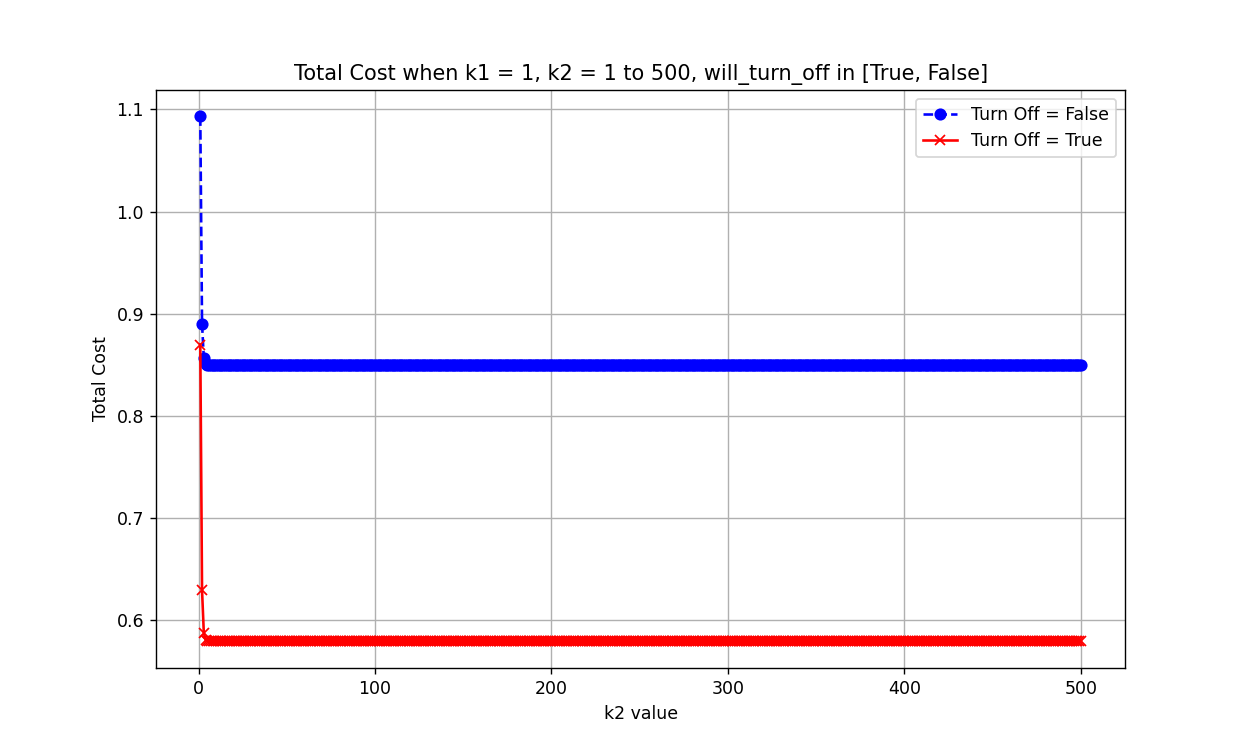

In [154]:
import matplotlib.pyplot as plt
import numpy as np

'''
Plot the above total cost results into visualized diagrams
While the mouse cursor approaches curves, it will show k2 values and the power consumption value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_total_cost_0():
    jobs_range = list(range(1, len(cost_plots_0) + 1))

    fig, ax = plt.subplots(figsize=(10, 6))

    line1, = ax.plot(jobs_range, cost_plots_0, label='Turn Off = False', color='blue', linestyle='--', marker='o')
    line2, = ax.plot(jobs_range, cost_plots_1, label='Turn Off = True', color='red', linestyle='-', marker='x')

    ax.set_xlabel('k2 value')
    ax.set_ylabel('Total Cost')
    ax.set_title('Total Cost when k1 = 1, k2 = 1 to 500, will_turn_off in [True, False]')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.8f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for line in [line1, line2]:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(ind, line)
                    fig.canvas.draw_idle()
                    return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()

plot_total_cost_0()

<IPython.core.display.Javascript object>


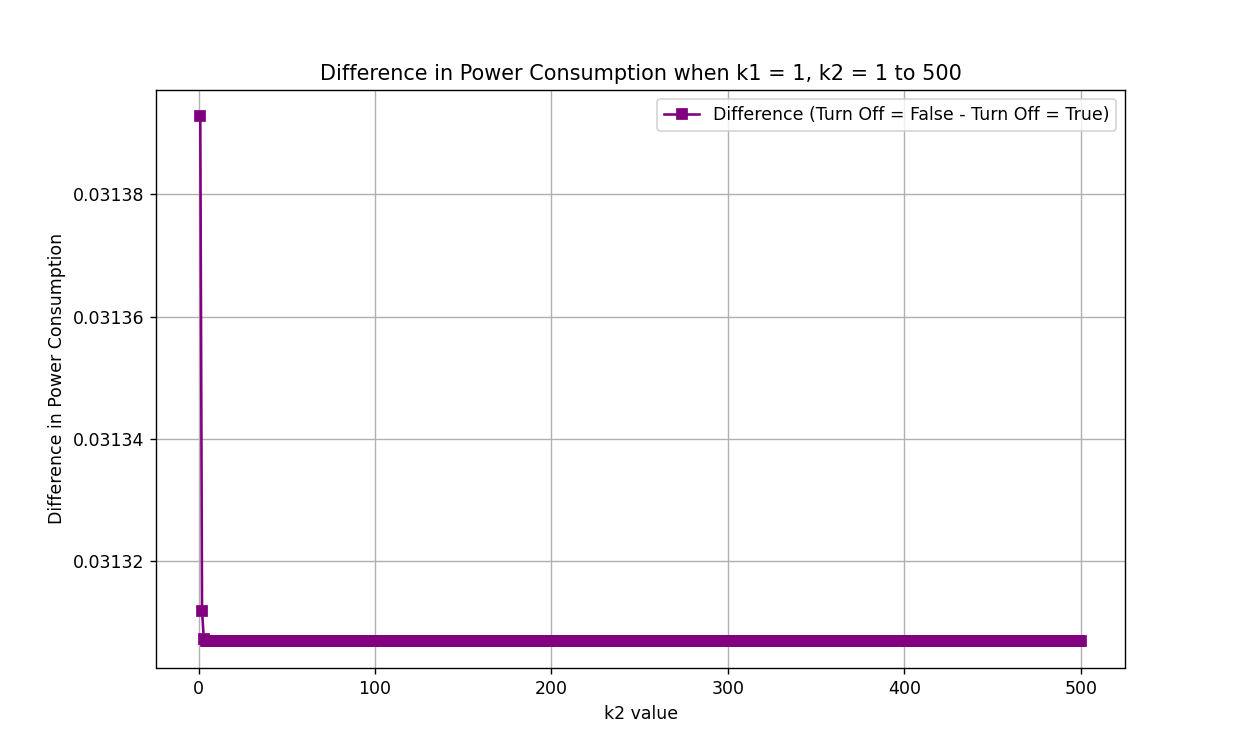

In [94]:
import matplotlib.pyplot as plt
import numpy as np

'''
Calculate both total cost list's differences and plot them on a diagram
While the mouse cursor approaches curves, it will show k2 values and the total cost value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_cost_differences_0():
    differences = np.array(cost_plots_0) - np.array(cost_plots_1)
    
    jobs_range = list(range(1, len(differences) + 1))
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(jobs_range, differences, label='Difference (Turn Off = False - Turn Off = True)', color='purple', linestyle='-', marker='s')

    ax.set_xlabel('k2 value')
    ax.set_ylabel('Difference in Power Consumption')
    ax.set_title('Difference in Power Consumption when k1 = 1, k2 = 1 to 500')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.20f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind, line)
                fig.canvas.draw_idle()
                return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

plot_cost_differences_0()

<p><b><a class="anchor" id="sbs5-2">Sub-section 2</a></b>: Binary search when k1 = k2, both k1 and k2 from 1 to 500</p>

In [95]:
import numpy as np
import pandas as pd
import time
from itertools import product

# Count this program's running time
start_time = time.time()

def grid_search_cost_1():
    global power_OFF_idle, power_OFF_on, power_ON_reg, power_ON_enhanced
    global k1, k2, will_turn_off
    global cost_plots_2, cost_plots_3
    # Initial parameters set up
    initialize_parameters()
    setup_States()
    exception_handling()
    setup_Transition_Matrix()

    best_params = [0, 0, False]
    best_cost = float('inf')

    # Record all parameter groups' total cost values (For further plots)
    # cost_plots_2: plots when will_turn_off = False
    # cost_plots_3: plots when will_turn_off = True
    cost_plots_2 = []
    cost_plots_3 = []
    
    i = 1
    for j, will_turn_off in product(range(i, max_jobs + 1), [True, False]):
        i = j
        k1 = i
        k2 = j
        will_turn_off = will_turn_off

        setup_Transition_Matrix()
        calculate_Steady_State(False, False)
        calculate_Power_Consumption()
        calculate_Cost(steady_state_df)

        # Add total consumption values inside the plot list
        if not will_turn_off:
            cost_plots_2.append(total_cost)
        else:
            cost_plots_3.append(total_cost)
        
        if total_cost < best_cost:
            best_cost = total_cost
            best_params = [k1, k2, will_turn_off]

    return best_params, best_cost

best_params, best_cost = grid_search_cost_1()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: k1={best_params[0]}, k2={best_params[1]}, will_turn_off={best_params[2]}")
print(f"Minimum Total Cost: {best_cost}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: k1=1, k2=1, will_turn_off=True
Minimum Total Cost: 0.07145529144464888
Elapsed Time: 90.50 seconds


<p><b><a class="anchor" id="sbss5-2-1">Sub-section 2</a></b>- Results' Visualization</p>

In [96]:
# Enable plot interactivity
%matplotlib notebook

<IPython.core.display.Javascript object>


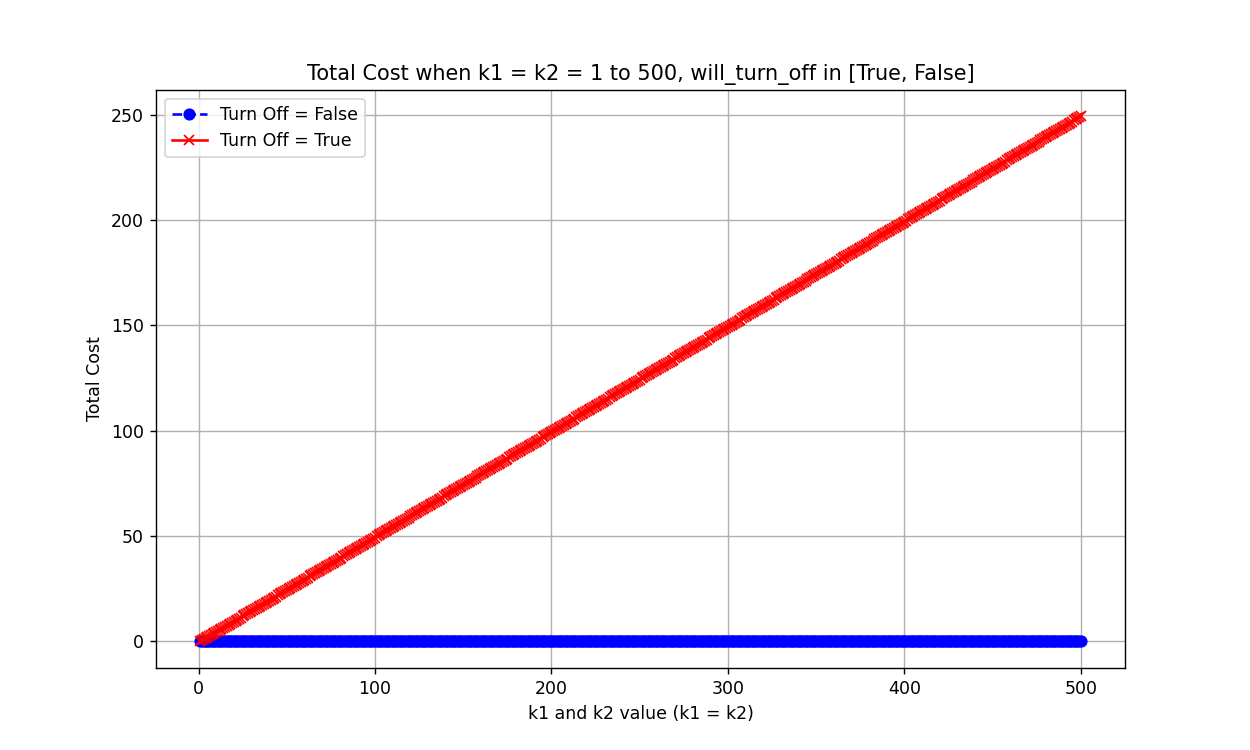

In [97]:
import matplotlib.pyplot as plt
import numpy as np

'''
Plot the above total cost results into visualized diagrams
While the mouse cursor approaches curves, it will show k2 values and the total cost value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_total_cost_1():
    jobs_range = list(range(1, len(cost_plots_2) + 1))

    fig, ax = plt.subplots(figsize=(10, 6))

    line1, = ax.plot(jobs_range, cost_plots_2, label='Turn Off = False', color='blue', linestyle='--', marker='o')
    line2, = ax.plot(jobs_range, cost_plots_3, label='Turn Off = True', color='red', linestyle='-', marker='x')

    ax.set_xlabel('k1 and k2 value (k1 = k2)')
    ax.set_ylabel('Total Cost')
    ax.set_title('Total Cost when k1 = k2 = 1 to 500, will_turn_off in [True, False]')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.8f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for line in [line1, line2]:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(ind, line)
                    fig.canvas.draw_idle()
                    return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()

plot_total_cost_1()

<IPython.core.display.Javascript object>


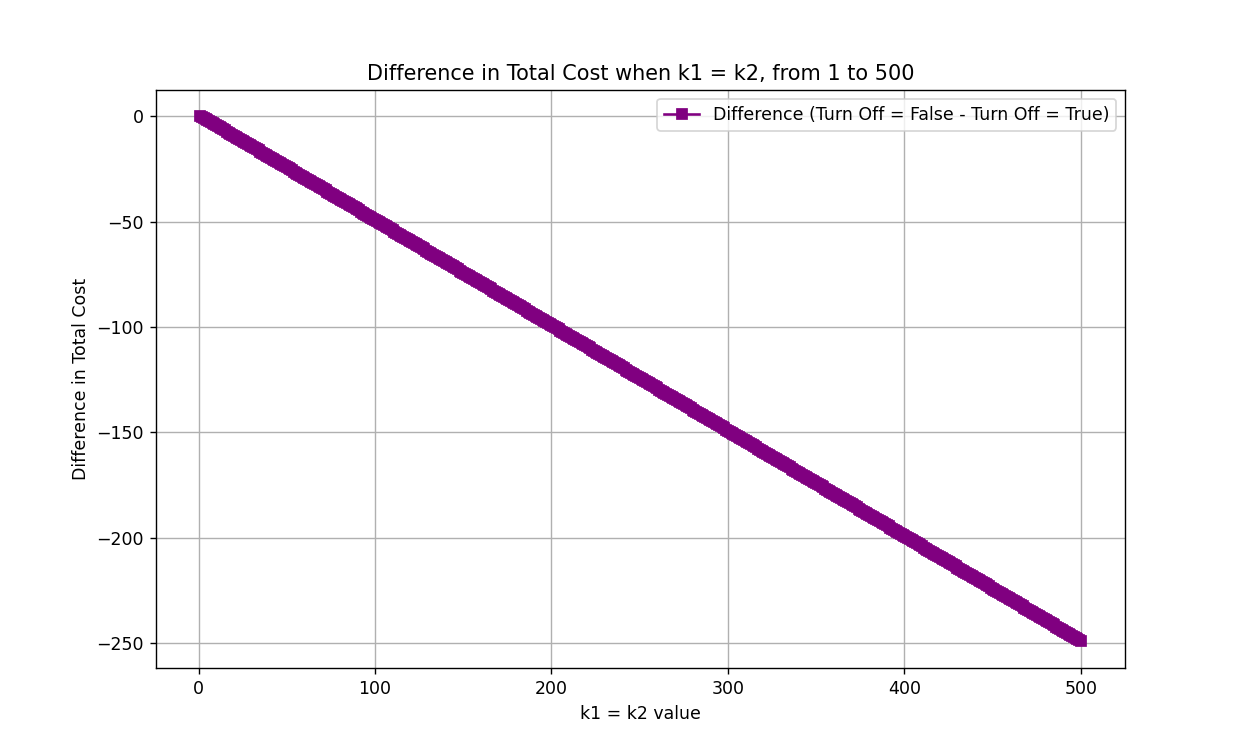

In [98]:
import matplotlib.pyplot as plt
import numpy as np

'''
Calculate both power consumption list's differences and plot them on a diagram
While the mouse cursor approaches curves, it will show k2 values and the power consumption value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_cost_differences_1():
    differences = np.array(cost_plots_2) - np.array(cost_plots_3)
    
    jobs_range = list(range(1, len(differences) + 1))
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(jobs_range, differences, label='Difference (Turn Off = False - Turn Off = True)', color='purple', linestyle='-', marker='s')

    ax.set_xlabel('k1 = k2 value')
    ax.set_ylabel('Difference in Total Cost')
    ax.set_title('Difference in Total Cost when k1 = k2, from 1 to 500')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.20f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind, line)
                fig.canvas.draw_idle()
                return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

plot_cost_differences_1()

<p><b><a class="anchor" id="sbs5-3">Sub-section 3</a></b>: Binary search when k1 = 1 to 500 and k2 = 500</p>

In [99]:
import numpy as np
import pandas as pd
import time
from itertools import product

# Count this program's running time
start_time = time.time()

def grid_search_cost_2():
    global power_OFF_idle, power_OFF_on, power_ON_reg, power_ON_enhanced
    global k1, k2, will_turn_off
    global cost_plots_4, cost_plots_5
    # Initial parameters set up
    initialize_parameters()
    setup_States()
    exception_handling()
    setup_Transition_Matrix()

    best_params = [0, 0, False]
    best_cost = float('inf')

    # Record all parameter groups' total cost values (For further plots)
    # cost_plots_4: plots when will_turn_off = False
    # cost_plots_5: plots when will_turn_off = True
    cost_plots_4 = []
    cost_plots_5 = []
    
    j = 500
    for i, will_turn_off in product(range(1, max_jobs + 1), [True, False]):
        k1 = i
        k2 = j
        will_turn_off = will_turn_off

        setup_Transition_Matrix()
        calculate_Steady_State(False, False)
        calculate_Power_Consumption()
        calculate_Cost(steady_state_df)

        # Add power consumptions inside the plot list
        if not will_turn_off:
            cost_plots_4.append(total_cost)
        else:
            cost_plots_5.append(total_cost)
        
        if total_cost < best_cost:
            best_cost = total_cost
            best_params = [k1, k2, will_turn_off]

    return best_params, best_cost

best_params, best_cost = grid_search_cost_2()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: k1={best_params[0]}, k2={best_params[1]}, will_turn_off={best_params[2]}")
print(f"Minimum Total Cost: {best_cost}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: k1=1, k2=500, will_turn_off=True
Minimum Total Cost: 0.07382468124738964
Elapsed Time: 91.15 seconds


<p><b><a class="anchor" id="sbss5-3-1">Sub-section 3</a></b>- Results' Visualization</p>

In [100]:
# Enable plot interactivity
%matplotlib notebook

<IPython.core.display.Javascript object>


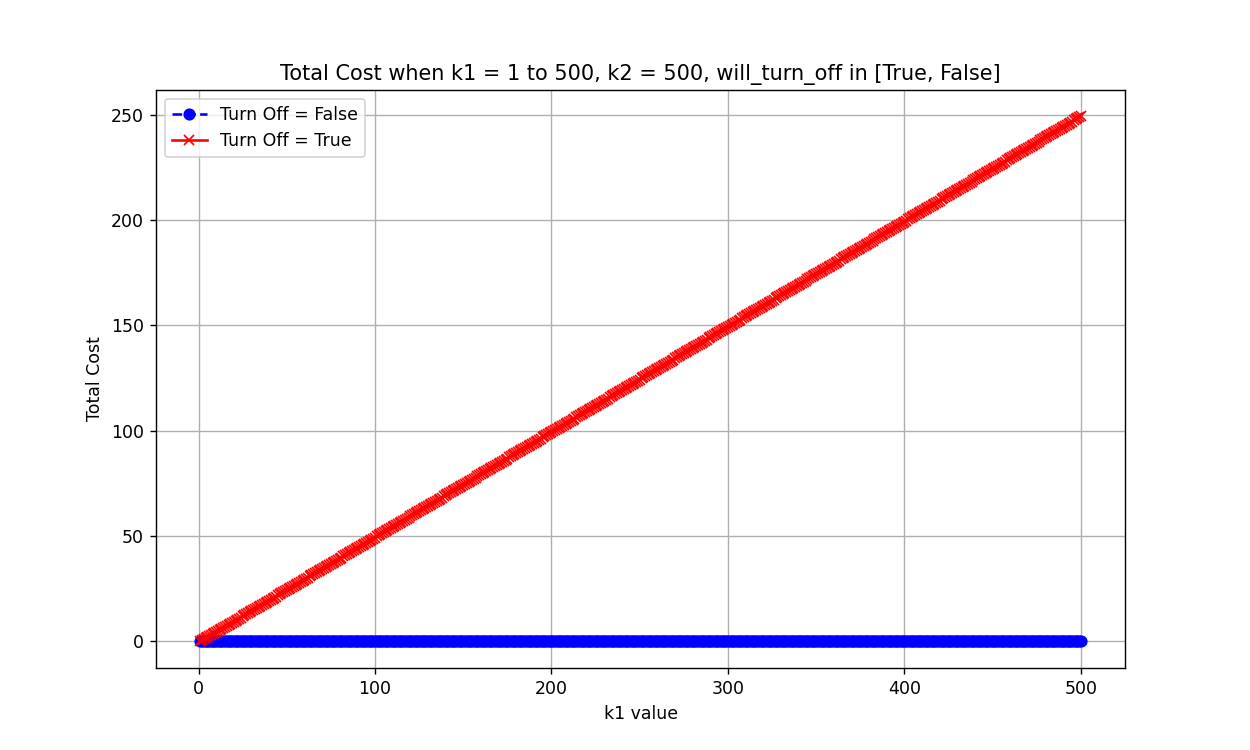

In [101]:
import matplotlib.pyplot as plt
import numpy as np

'''
Plot the above total cost results into visualized diagrams
While the mouse cursor approaches curves, it will show k2 values and the total cost value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_total_cost_2():
    jobs_range = list(range(1, len(cost_plots_4) + 1))

    fig, ax = plt.subplots(figsize=(10, 6))

    line1, = ax.plot(jobs_range, cost_plots_4, label='Turn Off = False', color='blue', linestyle='--', marker='o')
    line2, = ax.plot(jobs_range, cost_plots_5, label='Turn Off = True', color='red', linestyle='-', marker='x')

    ax.set_xlabel('k1 value')
    ax.set_ylabel('Total Cost')
    ax.set_title('Total Cost when k1 = 1 to 500, k2 = 500, will_turn_off in [True, False]')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.8f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for line in [line1, line2]:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(ind, line)
                    fig.canvas.draw_idle()
                    return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()

plot_total_cost_2()

<IPython.core.display.Javascript object>


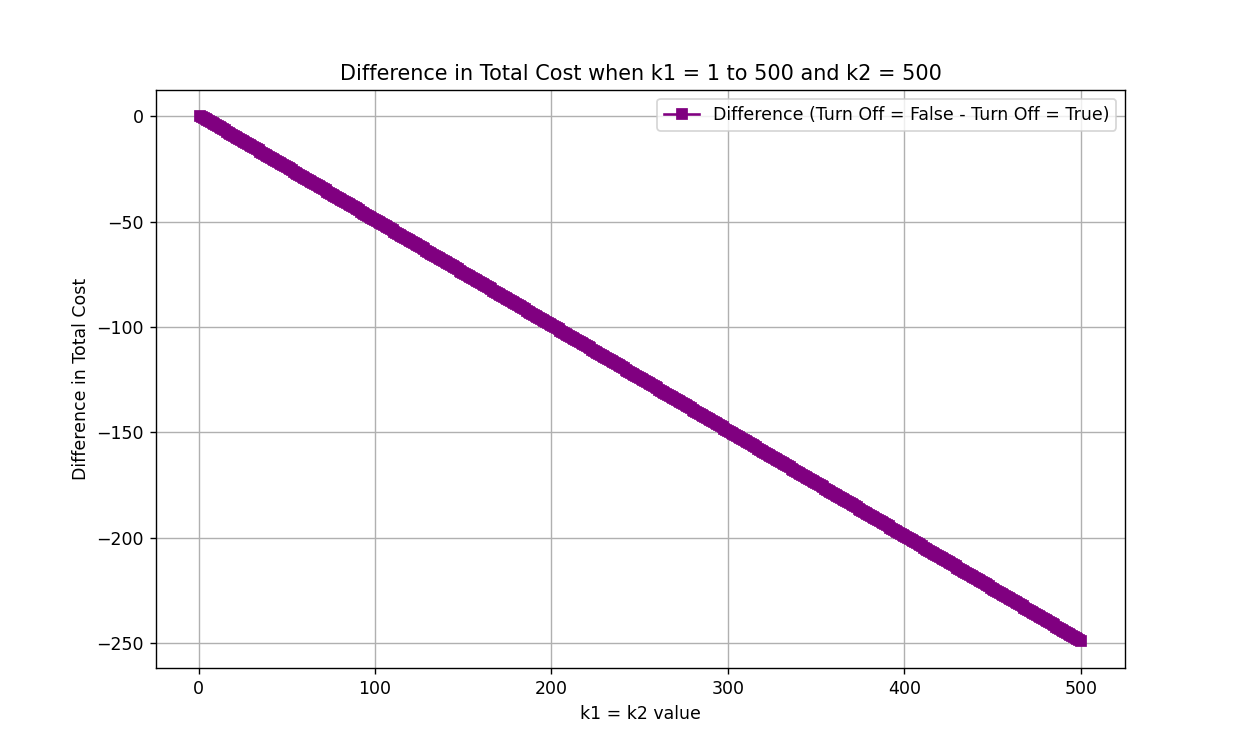

In [102]:
import matplotlib.pyplot as plt
import numpy as np

'''
Calculate both total cost list's differences and plot them on a diagram
While the mouse cursor approaches curves, it will show k2 values and the total cost value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_cost_differences_2():
    differences = np.array(cost_plots_4) - np.array(cost_plots_5)
    
    jobs_range = list(range(1, len(differences) + 1))
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(jobs_range, differences, label='Difference (Turn Off = False - Turn Off = True)', color='purple', linestyle='-', marker='s')

    ax.set_xlabel('k1 = k2 value')
    ax.set_ylabel('Difference in Total Cost')
    ax.set_title('Difference in Total Cost when k1 = 1 to 500 and k2 = 500')
    ax.legend()
    ax.grid(True)
    
    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.20f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind, line)
                fig.canvas.draw_idle()
                return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

plot_cost_differences_2()